# Spectral domain analysis 

In this tutorial, we will demonstrate how to use the spectral (or, frequency) domain analysis functions in neurodsp.spectral. We will cover:
- computing the power spectral density (PSD)
- fitting the 1/f noise in the PSD with a line in loglog domain
- computing and displaying the spectral histogram
- computing the spectral coefficient of variation (SCV) and the resampled estimates

Detailed explanations for each of the above concept are provided below as we come across them.

In [6]:
# importing libraries
%matplotlib inline
from scipy import signal
import numpy as np
import scipy as sp
from scipy import io
import matplotlib.pylab as plt
from neurodsp import spectral, plts

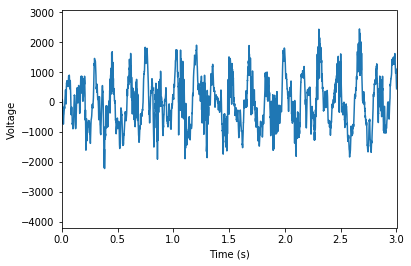

In [2]:
# first, we load the sample data, which is a segment of rat hippocampal LFP taken from the 
#    publicly available neuro database CRCNS (hc2). Relevant publication: Mizuseki et al, 2012, Nature Neuro
data = io.loadmat('./data/sample_data_2.mat', squeeze_me=True)
x = data['x']
fs = data['fs']
t = np.arange(len(x))/fs
plt.plot(t, x)
plt.xlim((0,3))
plt.xlabel('Time (s)')
plt.ylabel('Voltage')
plt.show()

# plotting the data, we observe a strong theta oscillation (~6-8 Hz)

### Computing the power spectral density (PSD)
PSD is the frequency domain representation of time series. Through the Fourier transform, the signal is split into orthogonal components of different frequency. In this toolbox, there are a few ways of estimating the PSD:
- 'mean' : same as Welch's method; mean over spectrogram of data. This is the most straightforward and "standard" way of computing the PSD.
- 'median' : similar to Welch's method; median (instead of mean) over spectrogram of data. This diminishes the effect of outlier power values from signal artifacts.
- 'medfilt' : median filtered of FFT magnitude squared.

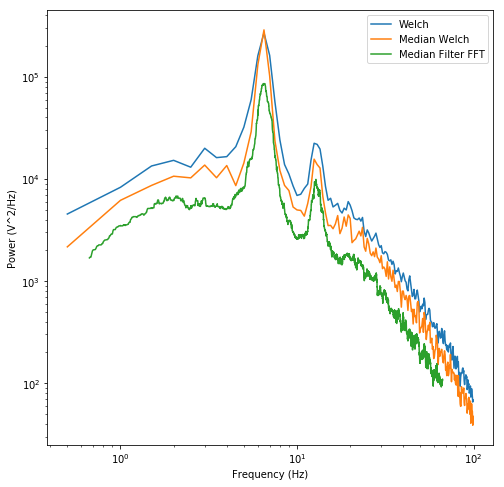

In [3]:
freq_mean, P_mean = spectral.psd(x, fs, method='mean', nperseg=fs*2) # mean of spectrogram (Welch)
freq_med, P_med = spectral.psd(x, fs, method='median', nperseg=fs*2) # median of spectrogram ("median Welch")
freq_mf, P_mf = spectral.psd(x, fs, method='medfilt')

plt.figure(figsize=(8,8))
plt.loglog(freq_mean[:200],P_mean[:200], label='Welch')
plt.loglog(freq_med[:200],P_med[:200], label='Median Welch')
plt.loglog(freq_mf[100:10000],P_mf[100:10000], label='Median Filter FFT')
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (V^2/Hz)')
plt.show()

### Fitting 1/f noise of PSD with a straight line in loglog scale
Notice in the above PSDs that there is a region of linear decrease when plotted in double log-scale, between 30-100Hz. This "1/f slope" has been found to correlate with aging, memory, and cognitive control in several previous publications, and has been proposed to reflect the physiological balance between excitation and inhibition. 

See for example: Voytek et al., JNeuro, 2015; Podvalny et al., JNeurophysiol, 2015; Gao et al., NeuroImage, 2017; Lombardi et al., Chaos, 2017

Here, we can fit the 1/f slope between any two frequencies while excluding a number of frequency ranges within that fit region, and we can plot the PSD and line to visually evaluate goodness of fit.

<div class="alert alert-info">
Spectral parameterization (in particular, the 1/f aperiodic component) has been discontinued from neurodsp. 
<br>
<br>
Please refer to [FOOOF](https://github.com/voytekresearch/fooof) for a complete and up-to-date spectral parameterizaton.
</div>


### Spectral histogram
The PSD is an estimate of the central tendency (mean/median) of the signal's power at each frequency, with the assumption that the signal is relatively stationary and that the variance around the mean comes from various forms of noise. 

However, in physiological data, we may be interested in visualizing the distribution of power values around the mean at each frequency, as estimated in sequential slices of short-time Fourier transform (STFT), since it may reveal non-stationarities in the data or particular frequencies that are not like the rest. Here, we simply bin the log-power values across time, in a histogram, to observe the noise distribution at each frequency.

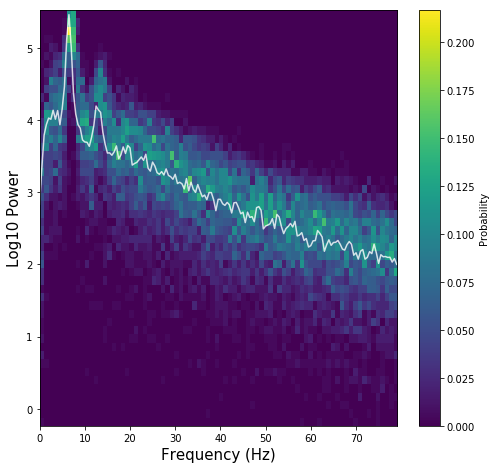

In [9]:
f, bins, spect_hist = spectral.spectral_hist(x, fs, nbins=50, flim=(0,80), cutpct=(0.1,99.9))
plts.plot_spectral_hist(f, bins, spect_hist, freq_med, P_med)

# Notice in the below plot that not only is theta power higher overall (shifted up), 
#    it also has lower variance around its mean.

### Spectral Coefficient of Variation
As noted above, the range of log-power values in the theta frequency range is lower compared to other frequencies, while that of 30-100Hz appear to be quite constant across the entire frequency axis (homoscedasticity). To quantify that, we compute the coefficient of variation (standard deviation/mean) as a normalized estimate of variance.

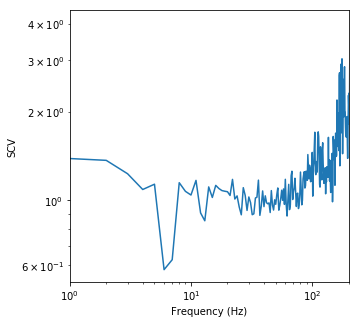

In [14]:
f, scv = spectral.scv(x, fs, nperseg=int(fs),noverlap=0)
plt.figure(figsize=(5,5))
plt.loglog(f,scv)
plt.xlim([1, 200])
plt.xlabel('Frequency (Hz)')
plt.ylabel('SCV')
plt.show()

As shown above, SCV calculated from the entire segment of data is quite noise due to the single estimate of mean and standard deviation. To overcome this, we can compute a bootstrap-resampled estimate of SCV, by randomly drawing slices from the non-overlapping spectrogram and taking their average.

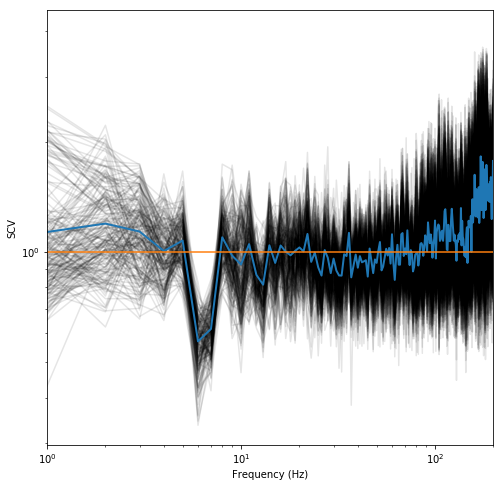

In [17]:
f, T, SCVrs = spectral.scv_rs(x, fs,nperseg=fs, method='bootstrap', rs_params=(20, 200))
plt.figure(figsize=(8,8))
plt.loglog(f, SCVrs, 'k', alpha=0.1);
plt.loglog(f, np.mean(SCVrs, axis=1), lw=2)
plt.loglog(f, len(f)*[1.])
plt.xlim((1,200))
plt.xlabel('Frequency (Hz)')
plt.ylabel('SCV')
plt.show()

Another way to compute the resampled SCV is via a sliding window approach, essentially smoothing over consecutive slices of the spectrogram to compute the mean and std estimates.

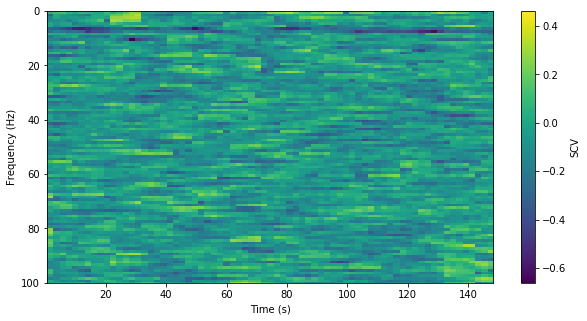

In [21]:
f, T, SCVrs = spectral.scv_rs(x, fs, method='rolling', rs_params=(10,2))
plt.figure(figsize=(10,5))
plt.imshow(np.log10(SCVrs), aspect='auto', extent=(T[0],T[-1],f[-1],f[0]))
plt.colorbar(label='SCV')
plt.ylim((100,0))
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.show()

# In the plot below, we see that the theta band (~7Hz) consistently has CV of less than 1 (negative in log10)

### Spectral Rotation
Another included utility function is spectral rotation, which rotates the power spectrum about a given axis frequency, by an amount indicated by the exponent (negative is clockwise, positive is counterclockwise).

This function is mostly useful for investigating the effect of rotating the spectrum in frequency domain on the time domain signal. Effectively, this performs a very specific type of filtering with an ultra long filter kernel.

For complete details, see the **Simulation** tutorial.

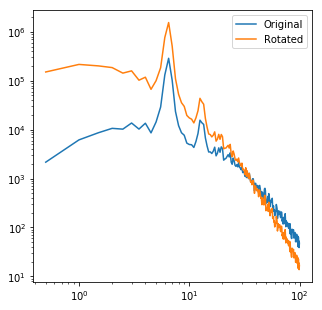

In [31]:
P_rot = spectral.rotate_powerlaw(freq_med,P_med,delta_f=-1,f_rotation=35)
plt.figure(figsize=(5,5))
plt.loglog(freq_med[:200], P_med[:200], label='Original')
plt.loglog(freq_med[:200], P_rot[:200], label='Rotated')
plt.legend()